# loadding data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/data/yltang/classification_model_2/classification_model") 

In [2]:
from matplotlib import font_manager

In [ ]:
font_manager.fontManager.addfont("/home/yltang/.local/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Times New Roman.ttf")

In [4]:
plt.style.use('classic')
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size':20,
         }

In [ ]:
number = 6

In [6]:
from load_tensor_new import load_tensor
data_dict = load_tensor(time_to_mask=number)

In [7]:
train_data = data_dict["train_data"]
train_label = data_dict["train_label"]
test_data = data_dict["test_data"]
test_label = data_dict["test_label"]

train_data_mask = data_dict["train_data_mask"]
#train_label_mask = data_dict["train_label_mask"]
test_data_mask = data_dict["test_data_mask"]
#test_label_mask = data_dict["test_label_mask"]

In [8]:
train_data_mask.shape, train_label.shape, train_data.shape

((450, 40, 6), (450, 40, 9), (450, 40, 6))

In [9]:
test_data_mask.shape, test_label.shape, test_data.shape

((1800, 40, 6), (1800, 40, 10), (1800, 40, 6))

In [10]:
num=0
num_band = 3
color = ['r','g','b','k','y','m']
fmt = ['.r','.g','.b','.k','.y','.m']
labels = ['u','g','r','i','z','y']
sampling_intervals=1

In [11]:
def normalize_data(data_to_norm):
    scale = []  

    for sample in range(data_to_norm.shape[0]):
        scale_ = max(data_to_norm[sample, :, 0])
        for features in range(num_band):
            if max(data_to_norm[sample, :, features]) >= scale_:
                scale_ = max(data_to_norm[sample, :, features])
        scale.append(scale_)    
        
    for sample in range(data_to_norm.shape[0]):
        for features in range(num_band):
            data_to_norm[sample, :, features] = data_to_norm[sample, :, features]/scale[sample]
            data_to_norm[sample, :, features + num_band] = data_to_norm[sample, :, features + num_band]/scale[sample]
    return data_to_norm 

In [12]:
train_data = normalize_data(data_to_norm=train_data)
train_data_mask = normalize_data(data_to_norm=train_data_mask)

test_data = normalize_data(data_to_norm=test_data)
test_data_mask = normalize_data(data_to_norm=test_data_mask)

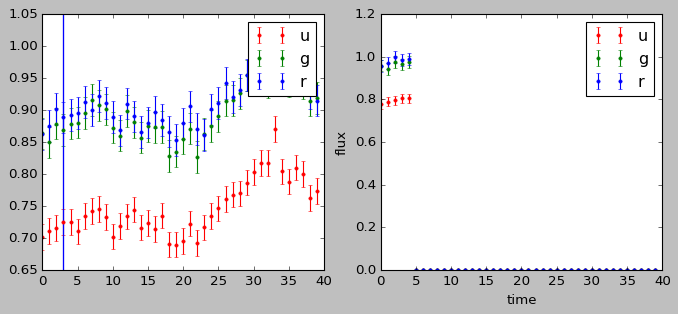

In [13]:
import matplotlib.pyplot as plt
#num = 0
num = num + 1
plt.figure(figsize=(5*2,4))
for i in range(num_band):
    mjd_1 = np.linspace(0,int(40/sampling_intervals)-1,int(40/sampling_intervals))
    
    original_flux = train_data[num,:,i]
    original_flux_err = train_data[num,:,i+num_band]

    observed_flux = train_data_mask[num,:,i]
    observed_flux_err = train_data_mask[num,:,i+num_band]
    
    plt.subplot(1,2,1)
    plt.errorbar(x=mjd_1, y=original_flux, yerr=original_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.axvline(x=2+num)
    plt.legend()

    plt.subplot(1,2,2)
    plt.errorbar(x=mjd_1, y=observed_flux, yerr=observed_flux_err, fmt=fmt[i], capsize=2,label=labels[i])
    plt.legend()
    #plt.xlim(min(mjd_2),4)
    #for j in Nan_data_position_list[num]:
    #    plt.axvline(x=j)
    plt.xlabel("time")
    plt.ylabel("flux")

In [14]:
train_label = train_label[:, 29, :]
test_label = test_label[:, 29, :]
#validat_label = validat_label[:, 49, :]

In [15]:
train_label.shape, test_label.shape

((450, 9), (1800, 10))

# model 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-10-22 16:24:06.181165: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 16:24:06.223987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#input features
num_time_steps = train_data.shape[1]
num_features = int(train_data.shape[2])

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, TimeDistributed, Masking
from tensorflow.keras.models import Sequential, Model

## encoder

In [18]:
model = Sequential()
model.add(Masking(mask_value=0.))
model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(Dropout(0.2, seed=42))
model.add(BatchNormalization())
model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(Dropout(0.2, seed=42))
model.add(BatchNormalization())
model.add(Dropout(0.2, seed=42))
model.add(TimeDistributed(Dense(10, activation='softmax')))

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(90, 6))
#recurrent branch
x = layers.Masking(mask_value=0.0)(encoder_inputs)
x = layers.GRU(64,return_sequences=True)(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.BatchNormalization()(x)
x = layers.GRU(64,return_sequences=True)(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2, seed=42)(x)
x = layers.TimeDistributed(layers.Dense(32, activation="relu"))(x)

z_mean = layers.TimeDistributed(layers.Dense(latent_dim, activation="relu", name="z_mean"))(x)
z_log_var = layers.TimeDistributed(layers.Dense(latent_dim, activation="relu", name="z_log_var"))(x)
classification_probability = layers.TimeDistributed(layers.Dense(9, activation="softmax",name="classification_probability"))(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, classification_probability], name="encoder")

latent_inputs = keras.Input(shape=(num_time_steps, latent_dim))
x_1 = layers.GRU(100,return_sequences=True)(latent_inputs)
x_1 = layers.GRU(100,return_sequences=True)(x_1)
x_1 = layers.Dense(64, activation="relu")(x_1)
x_1 = layers.Dense(32, activation="relu")(x_1)
decoder_outputs = layers.Dense(num_features, activation="relu")(x_1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

2024-10-22 16:47:39.464868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-22 16:47:39.466090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-22 16:47:39.467657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [22]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 90, 6)]      0           []                               
                                                                                                  
 masking_6 (Masking)            (None, 90, 6)        0           ['input_12[0][0]']               
                                                                                                  
 gru_18 (GRU)                   (None, 90, 64)       13824       ['masking_6[0][0]']              
                                                                                                  
 dropout_18 (Dropout)           (None, 90, 64)       0           ['gru_18[0][0]']                 
                                                                                            

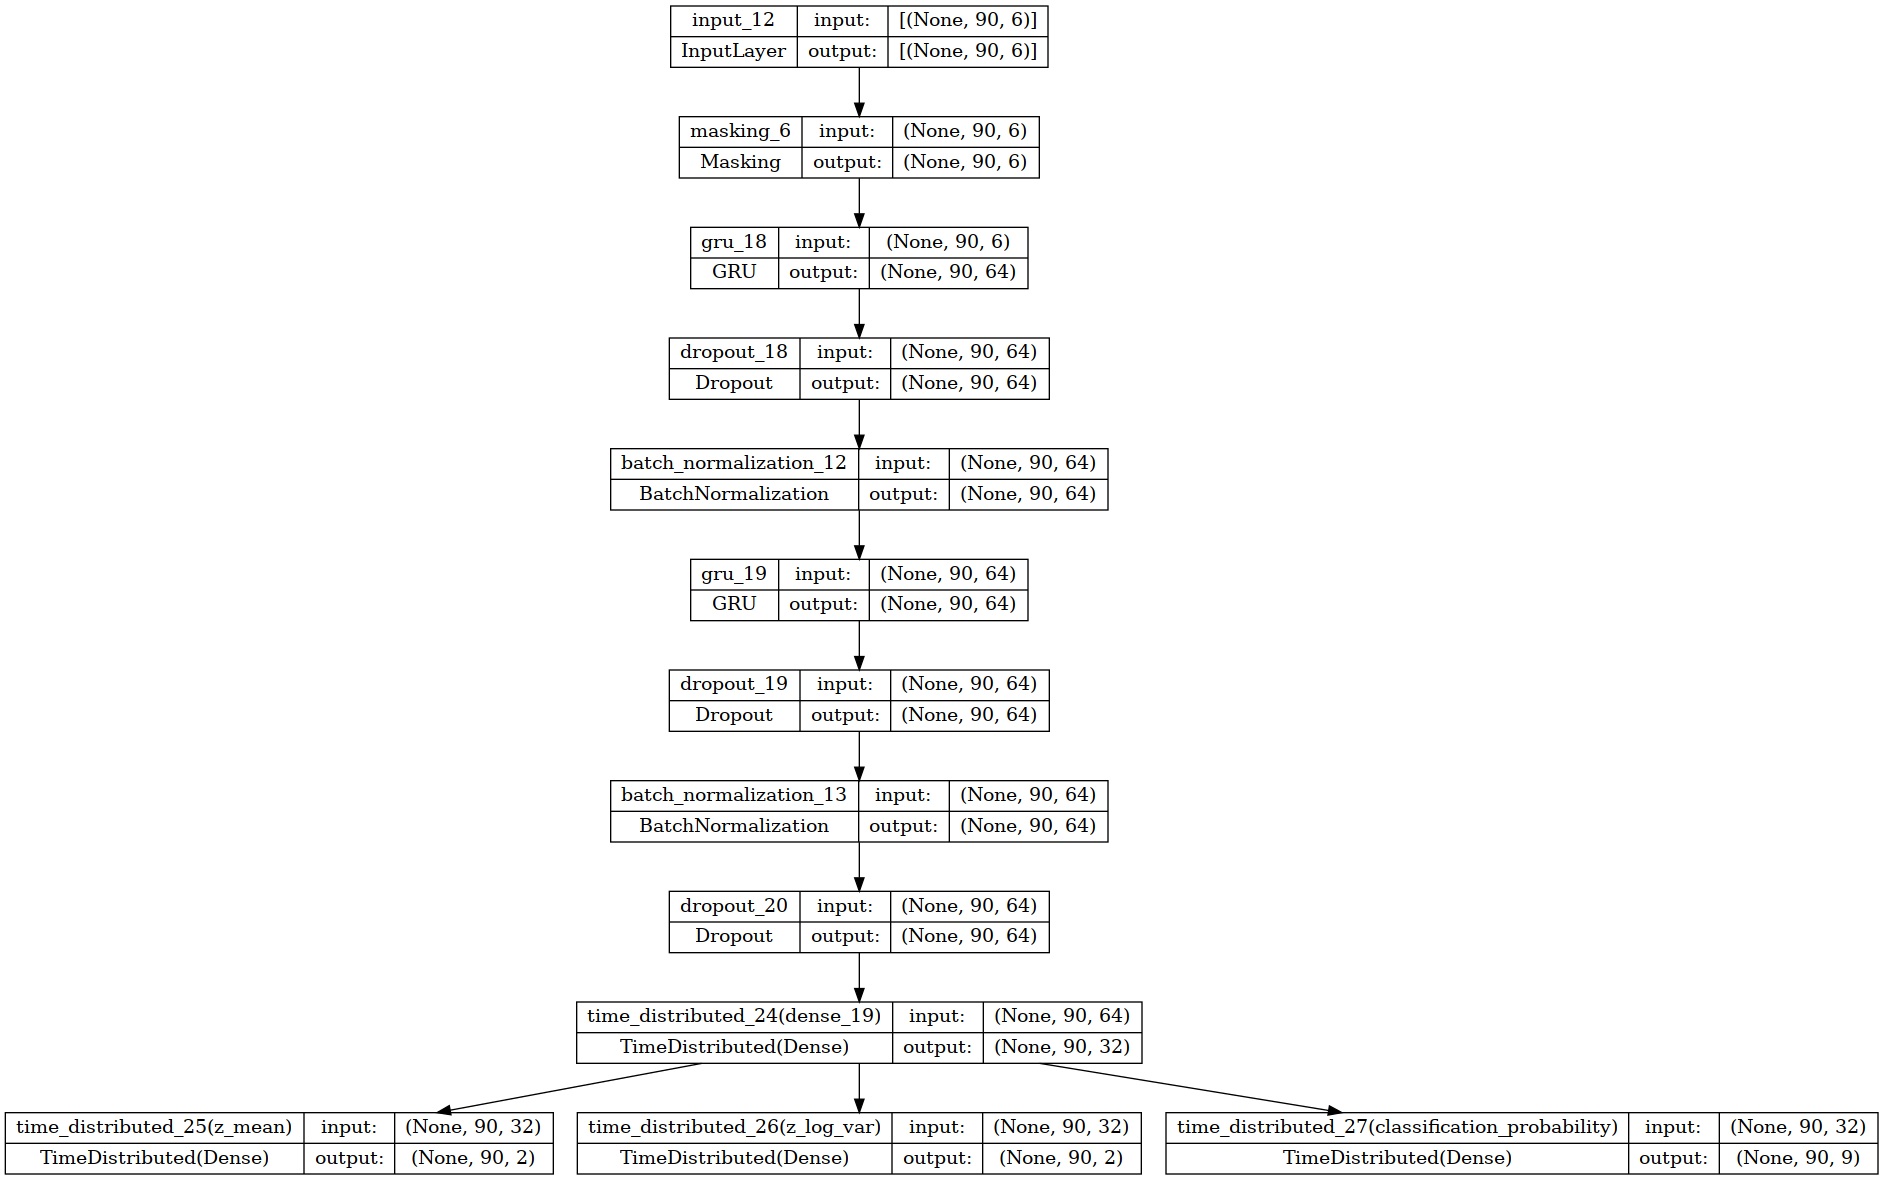

In [23]:
keras.utils.plot_model(encoder, show_shapes=True)

In [24]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon * 0.1

## decoder

In [25]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 90, 2)]           0         
                                                                 
 gru_20 (GRU)                (None, 90, 100)           31200     
                                                                 
 gru_21 (GRU)                (None, 90, 100)           60600     
                                                                 
 dense_20 (Dense)            (None, 90, 64)            6464      
                                                                 
 dense_21 (Dense)            (None, 90, 32)            2080      
                                                                 
 dense_22 (Dense)            (None, 90, 6)             198       
                                                                 
Total params: 100,542
Trainable params: 100,542
Non-trainab

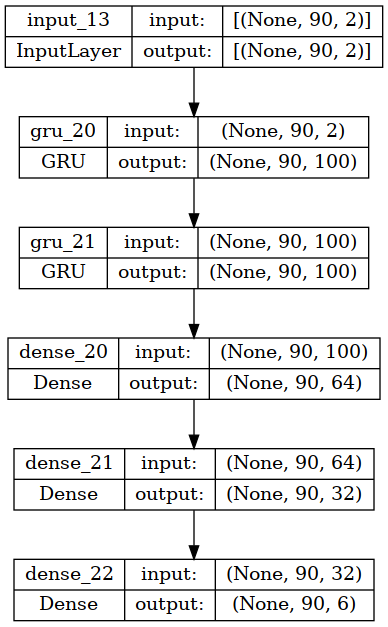

In [26]:
keras.utils.plot_model(decoder, show_shapes=True)

# try to add restriction to the variation autoencoder

In [27]:
classification_weight = 10
reconstruction_weight = 0.1

In [28]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.classification_tracker = keras.metrics.Mean(name="classification_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                self.classification_tracker
               ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, classification_probability= self.encoder(data[0])
            
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data[0], reconstruction)
                )
            )
            
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            classification_loss = keras.losses.categorical_crossentropy(data[1], classification_probability)*classification_weight
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss) + tf.reduce_mean(classification_loss)

            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.classification_tracker.update_state(classification_loss)
        
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "classification_loss": self.classification_tracker.result()
        }

In [25]:
train_data.shape,test_data.shape, test_data_mask.shape

((9440, 40, 6), (9440, 40, 6), (9440, 40, 6))

In [26]:
train_label.shape, test_label.shape

((9440, 9), (9440, 9))

In [ ]:
epochs = 5000
batch_size = 1024
vae = VAE(encoder, decoder)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_1.h5", save_best_only=True, monitor="classification_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="classification_loss", factor=0.5, patience=10, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="classification_loss", patience=200, verbose=1),
]
vae.compile(
    optimizer="rmsprop",
    run_eagerly=True
)

history = vae.fit(
    [train_data_mask, test_data_mask],
    [train_data, test_label],
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    #validation_split=0.2,
    verbose=1,
)

2024-05-17 19:45:22.181610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-17 19:45:22.199592: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3200000000 Hz
2024-05-17 19:45:22.249627: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Epoch 1/5000


2024-05-17 19:45:23.278119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


10/10 [==============================] - 2s 61ms/step - total_loss: 3595.4141 - reconstruction_loss: 3568.6187 - kl_loss: 4.4287 - classification_loss: 22.3908
Epoch 2/5000
10/10 [==============================] - 1s 61ms/step - total_loss: 1723.2897 - reconstruction_loss: 1696.8151 - kl_loss: 5.6849 - classification_loss: 20.8178
Epoch 3/5000
10/10 [==============================] - 1s 70ms/step - total_loss: 1254.3403 - reconstruction_loss: 1229.3577 - kl_loss: 5.3321 - classification_loss: 19.9062
Epoch 4/5000
10/10 [==============================] - 1s 70ms/step - total_loss: 1127.1215 - reconstruction_loss: 1103.4000 - kl_loss: 4.6859 - classification_loss: 19.1479
Epoch 5/5000
10/10 [==============================] - 1s 59ms/step - total_loss: 1080.3417 - reconstruction_loss: 1057.3680 - kl_loss: 4.8983 - classification_loss: 18.1428
Epoch 6/5000
10/10 [==============================] - 1s 61ms/step - total_loss: 810.1705 - reconstruction_loss: 787.9350 - kl_loss: 5.0176 - classi

In [29]:
metric = "loss"
for i, b in enumerate(history.history["classification_" + metric]):
    history.history["classification_" + metric][i] = history.history["classification_" + metric][i]/max(history.history["classification_" + metric])

for i, b in enumerate(history.history["reconstruction_" + metric]):
    history.history["reconstruction_" + metric][i] = history.history["reconstruction_" + metric][i]/max(history.history["reconstruction_" + metric])

#for i, b in enumerate(history.history["kl_" + metric]):
#   history.history["kl_" + metric][i] = history.history["kl_" + metric][i]/max(history.history["kl_" + metric])

In [ ]:
metric = "loss"
plt.figure()
#plt.plot(history.history["kl_"+metric])
plt.plot(history.history["reconstruction_" + metric])
plt.plot(history.history["classification_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["reconstruct_loss","classification"], loc="best")
plt.show()
plt.close()

In [31]:
vae.encoder.save(f"LSTM_encoder_early_1.h5")
vae.decoder.save(f"LSTM_decoder_early_1.h5")

In [18]:
from tensorflow.keras.models import load_model
vae_decoder = load_model(f"/data/yltang/paper_1/LSTM_decoder_early_e.h5")
vae_encoder = load_model(f"/data/yltang/paper_1/LSTM_encoder_early_e.h5")

2024-05-23 20:06:43.402166: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-23 20:06:43.403482: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-23 20:06:43.456686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.77GiB deviceMemoryBandwidth: 836.37GiB/s
2024-05-23 20:06:43.456734: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-23 20:06:43.458311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-23 20:06:43.458373: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [19]:
z_mean, z_log_var, pred = vae_encoder.predict(test_data_mask)

2024-05-23 20:06:46.520165: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-23 20:06:46.539570: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3200000000 Hz
2024-05-23 20:06:47.851289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-05-23 20:06:48.131764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
plt.figure(figsize=(12,10),
          dpi=1000)
colors = ["darkgrey", "lightgreen","aquamarine","lightblue","mediumpurple","plum","bisque","yellow","rosybrown","khaki","blue"]
colors_ = ["k",'green',"turquoise","blue","blueviolet","violet","darkorange","y","brown","darkkhaki","mediumblue"]
labels = [
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE']
markers = ["+", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "d"]
for i in range(len(colors)-2):
    plotlist = []
    for j in range(z_mean.shape[0]):
        #if np.argmax(test_label[j,0,:])==i:
        if np.argmax(test_label[j,:])==i:
            plotlist.append(j)
    mean_x = np.mean(z_mean[plotlist, 0])
    mean_y = np.mean(z_mean[plotlist, 1])
    var_x = np.var(z_mean[plotlist,0])
    var_y = np.var(z_mean[plotlist,1])
    print(f"mean_x:{mean_x} mean_y:{mean_y}, var_x:{var_x} var_y:{var_y}")
    
    x = np.linspace(mean_x-np.abs(var_x), mean_x+np.abs(var_x))
    x_ = np.zeros(shape=x.shape) + mean_x
    y = np.linspace(mean_y-np.abs(var_y), mean_y+np.abs(var_y))
    y_ =np.zeros(shape=y.shape) + mean_y
    
    #plt.plot(x,y_, color=colors_[i], linewidth=1.2)
    #plt.plot(x_,y,color=colors_[i], linewidth=1.2)
    #plt.scatter(mean_x, mean_y,s=60, c="k",marker='o', alpha=1)
    #plt.annotate(labels[i], xy = (mean_x, mean_y), xytext = (mean_x-0.2, mean_y-0.2), color=colors[i],fontsize="large",fontproperties="Times New Roman")
    # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    
    plt.scatter(
        z_mean[plotlist, 0],
        z_mean[plotlist, 1],
        c=colors[i],
        s=30,
        label=labels[i],
        marker=markers[i],
        alpha=0.6
                )
    
plt.xticks(fontsize="xx-large",fontproperties="Times New Roman")
plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")
    
plt.xlabel("latent_feature_1",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
plt.ylabel("latent_feature_2",fontsize="xx-large",labelpad=10,fontproperties="Times New Roman")
#plt.legend(fontsize="xx-large",bbox_to_anchor=(1.3, 1),loc="upper right",
#         prop=font1,
#         borderaxespad=0.)

plt.legend(fontsize="x-large",loc="best",
         prop=font1,
         framealpha=0.2,
         borderaxespad=0.)


plt.savefig(f"latent_distribution_{number}.jpg",bbox_inches='tight')
plt.show()

In [20]:
batch_size = tf.shape(z_mean)[0]
z_size = tf.shape(z_mean)[1]
epsilon  = tf.random.normal(shape=(batch_size, z_size))
#sampling_vector = z_mean + tf.exp(0.5 * z_log_var[3]) * epsilon

sampling_vector = z_mean
reconstuct  = vae_decoder(sampling_vector)

In [21]:
markers = ["d", "o", "v", "^", "<", ">", "1", "X", "p", "P", "*", "+"]
color = ['blueviolet','blue',"green",'orange','red','m']
fmt = ['dm','og','vr','^k','<y','>m']
label = ['u','g','r','i','z','y']

In [22]:
reconstuct.shape

TensorShape([1800, 40, 6])

In [23]:
id_ = 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.sans-serif'] = ['SimHei'] 
#plt.rcParams['axes.unicode_minus'] = False   

figure,(ax1,ax2,ax3) = plt.subplots(1,3,
                                    figsize=(6*3,5),
                                    dpi=1000,
                                    sharey=True)
#id_ = id_ + 1

ax_list = [ax1,ax2,ax3]
for i in range(num_band):
    mjd = np.linspace(0,39,40)
    flux_1 = test_data_mask[id_,:,i]
    flux_err_1 = test_data_mask[id_,:,i+num_band]

    flux_2 = reconstuct[id_,:,i]
    flux_err_2 = reconstuct[id_,:,i+num_band]
    

    flux_3 = test_data[id_,:,i]
    flux_err_3 = test_data[id_,:,i+num_band]
    
    flux_list = [flux_1,flux_2,flux_3]
    flux_err_list = [flux_err_1, flux_err_2,flux_err_3]
    
    for j in range(3):
        ax_list[j].errorbar(x=mjd, y=flux_list[j], yerr=flux_err_list[j],fmt=fmt[i], capsize=2,label=label[i])
        #ax_list[j].errorbar(x=mjd_1, y=flux_list[j], yerr=flux_err_list[j],color=color[i], marker=markers[i], capsize=2,label=label[i])
        if j==0:
            ax_list[j].set_ylabel("Normalized Flux",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
        elif j==1:
            ax_list[j].set_xlabel("Times",fontsize="xx-large",labelpad=30,fontproperties="Times New Roman")
        ax_list[j].legend(fontsize="xx-large",loc="upper right",prop=font1)
        x1_label = ax_list[j].get_xticklabels() 
        [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
        y1_label = ax_list[j].get_yticklabels() 
        [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]

        ax_list[j].tick_params(axis='y',
                     labelsize=20, 
                     #color='r',    
                     #labelcolor='b',
                     direction='in'
                      ) 
    
        ax_list[j].tick_params(axis='x',
                     labelsize=20, 
                     #color='r',    
                     #labelcolor='b', 
                     direction='in' 
                      ) 
        ax_list[i].legend(fontsize="x-large",
                      #bbox_to_anchor=(0,0.34,1.028, 1),
                      loc="upper right",
                      framealpha=0.2,
                      prop=font1
                     )
figure.subplots_adjust(wspace=0.05) 
plt.savefig("reconstruction.jpg",bbox_inches='tight')
plt.show()

In [25]:
guess=[]

for i in range (len(test_data_mask)):
    guess.append(np.argmax(pred[i,:]))

In [26]:
ture=[]

for i in range (len(test_data_mask)):
    ture.append(np.argmax(test_label[i,:]))

In [27]:
guess[:20],ture[:20]

([7, 4, 8, 3, 4, 1, 5, 8, 7, 8, 2, 4, 2, 0, 3, 2, 3, 1, 8, 6],
 [7, 4, 8, 3, 4, 1, 5, 8, 7, 8, 2, 4, 5, 0, 3, 2, 3, 1, 8, 6])

In [28]:
max(pred[0,:])

1.0

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

confusion = confusion_matrix(ture,guess,normalize='true')

In [30]:
import matplotlib

In [32]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, fraction=0.047)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labelsize=12,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.set_ylabel('True Label',fontsize="xx-large",labelpad=20,fontproperties="Times New Roman")
    ax.set_xlabel('Predicted Label',fontsize="xx-large",labelpad=30,fontproperties="Times New Roman",loc="center")
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), fontsize=12,**kw)
            texts.append(text)

    return texts

In [ ]:
fig, ax = plt.subplots(figsize=(10,10),
                      dpi=1000)
im, cbar = heatmap(data=confusion, row_labels=[
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE']
                      ,col_labels=[
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE'], ax=ax,
                   cmap="Blues")
texts = annotate_heatmap(im, valfmt="{x:.2f}")
fig.tight_layout()
plt.savefig(f"Confusion_matrix_{number}.jpg",bbox_inches='tight')
plt.show()

In [34]:
cm = confusion_matrix(ture,guess)

In [35]:
cm.shape

(9, 9)

In [ ]:
#precision recall
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

fig, ax = plt.subplots(figsize=(10,5),
                       dpi=1000
                      )
labels = ture
x = np.arange(9)  # the label locations
width = 0.4  # the width of the bars
rects1 = ax.bar((x- width/2), precision, width, label='Precision')
rects2 = ax.bar((x+ width/2), recall, width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',fontsize="xx-large",labelpad=20,fontproperties="Times New Roman")
#ax.set_title('Precision/Recall per class')
ax.set_xticks(x)
ax.set_xticklabels([
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
ax.tick_params(axis='y',
                         labelsize=15,
                         pad=10,
                         #color='r',    
                         #labelcolor='b',
                         direction='in' 
                          ) 
ax.tick_params(axis='x',
                         labelsize=15, 
                         pad=10,
                         #color='r',      
                         #labelcolor='b', 
                         direction='in'
                          ) 

plt.legend(fontsize="xx-large",
           #bbox_to_anchor=(0,0.3,1, 1),
           loc="upper right",
           framealpha=0.2,
           prop=font1,
           #borderaxespad=0.
          )
plt.savefig(f'PvsR_barplot.png')

In [40]:
precision

array([0.87645479, 0.81127733, 0.78042553, 0.99142551, 0.78285714,
       0.91563555, 0.97227723, 0.9916368 , 0.87321429])

In [41]:
recall

array([0.979, 0.705, 0.917, 0.925, 0.822, 0.814, 0.982, 0.83 , 0.978])

In [42]:
macro_P = np.mean(precision)
macro_R = np.mean(recall)
macro_F1 = (2*macro_P*macro_R)/(macro_P+macro_R)

print(macro_P, macro_R, macro_F1)

0.8883560178716022 0.8835555555555554 0.8859492840080282


In [43]:
def sort_probability_index(pred, label):
    probability_list = []
    for sample in range(len(pred)):
        probability_list.append(pred[sample][label])
    sorted_probability_index = sorted(range(len(probability_list)), key=lambda k:probability_list[k])
    return sorted_probability_index

In [68]:
from tqdm import tqdm
precision_list = []
recall_list = []
fpr_list = []
ture_array = np.array(ture)
pred_array = np.zeros(shape=(len(pred),))

In [69]:
ture[:10], ture_array[:10]

([8, 1, 2, 8, 5, 1, 0, 6, 6, 7], array([8, 1, 2, 8, 5, 1, 0, 6, 6, 7]))

In [70]:
print(pred[0])
print(pred_array[:10])

[1.6929372e-10 8.6124373e-06 8.0590806e-15 1.2397628e-07 4.0775129e-05
 7.3087797e-19 2.5267730e-07 5.7215611e-11 9.9995029e-01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [71]:
for labels in range(9):
    print(f"class {labels}")
    x_step = 1/ len(ture)
    recall_ = []
    fpr_ = []
    ture_ = []
    sorted_probability_index = sort_probability_index(pred=pred, label=labels)
    ture_array_ = ture_array.copy()
    pred_array_ = pred_array.copy()
    ture_array_ = ture_array_[sorted_probability_index]
    pred_array_ = pred_array_[sorted_probability_index]

    for sample in range(len(ture)):
        if ture_array_[sample] == labels:
            ture_.append(0)
        else:
            ture_.append(1)


    with tqdm(total=len(pred)*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar: 
        for i in range(len(pred)):
            guess_ = pred_array_.copy()
            guess_[i:] = 1
            
            cm = confusion_matrix(ture_,guess_)
            #print(cm)
            recall = cm.diagonal()[0]/np.sum(cm,axis=1)[0]
            FPR = (np.sum(cm,axis=0)[0]-cm.diagonal()[0])/np.sum(cm,axis=1)[1]
            #print(f"precision: {precision}, recall: {recall}, FPR: {FPR}")
            recall_.append(recall)
            fpr_.append(FPR)                
            pbar.update(10)
            
    recall_list.append(recall_)
    fpr_list.append(fpr_)

class 0


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:28<00:00, 3.18kB/s]


class 1


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:28<00:00, 3.21kB/s]


class 2


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:27<00:00, 3.27kB/s]


class 3


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:26<00:00, 3.41kB/s]


class 4


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:27<00:00, 3.32kB/s]


class 5


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:26<00:00, 3.34kB/s]


class 6


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:26<00:00, 3.39kB/s]


class 7


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:26<00:00, 3.42kB/s]


class 8


Processing...: 100%|███████████████████████████████████████████| 90.0k/90.0k [00:26<00:00, 3.35kB/s]


In [72]:
len(recall_list)

9

In [73]:
ROC_params = dict()
ROC_params[f'recall_list'] = recall_list
ROC_params[f'fpr_list'] = fpr_list
    

import json
ROC_params_json = json.dumps(ROC_params,sort_keys=False, indent=4, separators=(',', ': '))
print(type(ROC_params_json))
f = open(f'ROC_params_{number}.json', 'w')
f.write(ROC_params_json)
f.close()

<class 'str'>


In [ ]:
import json
ROC_params = open(f'ROC_params_{number}.json', 'r')
ROC_info = json.load(ROC_params)

In [32]:
fpr_list = ROC_info["fpr_list"]
recall_list = ROC_info["recall_list"]

In [34]:
AUC_list = []
for i in range(9):
    recall_list_plus = recall_list[i] + [1.0]
    del recall_list_plus[0]
    recall_step = np.array(recall_list_plus) - np.array(recall_list[i])
    AUC = 0
    for j, step in enumerate(recall_step):
        AUC = AUC + step * fpr_list[i][j]
    
    AUC_list.append(AUC)

In [35]:
colors = ["darkgrey", "lightgreen","aquamarine","lightblue","mediumpurple","plum","bisque","yellow","rosybrown","khaki","blue"]

In [ ]:
label = [
 'AGN',
 'SLSN',
 'SNIa',
 'SNII',
 'SNIbc',
 'SNIa-91bg',
 'SNIax',
 'KN',
 'TDE']
plt.figure(figsize=(12,10),
           dpi=1000)
for i in range(9):
    x = recall_list[i]
    y = fpr_list[i]
    plt.plot(x,y, label=f"{label[i]} AUC: {AUC_list[i]:.2f}",color=colors[i],lw=2.0, alpha=1.0)
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    #plt.plot(x,x)

    plt.ylabel("True Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman") 
    plt.xlabel("False Positive Rate",fontsize="xx-large", labelpad=20,fontproperties="Times New Roman")
    plt.legend(fontsize="xx-large",loc="lower right",prop=font1)
    plt.xticks(fontsize="xx-large",fontproperties="Times New Roman")
    plt.yticks(fontsize="xx-large",fontproperties="Times New Roman")

plt.savefig(f"ROC_curve_{number}.jpg",bbox_inches='tight')
plt.show()